### Imports

In [2]:
import sys
sys.path.append('../src')
import data_utils

import matplotlib.pyplot  as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import platform
import cv2
from skimage import io, feature, util, color
from skimage.feature import graycomatrix, graycoprops

import tensorflow as tf
from tensorflow import keras
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import os

print(platform.platform())
print(f"Tensorflow: {tf.__version__}")
print(f"Keras: {keras.__version__}")
tf.config.list_physical_devices('GPU')

macOS-12.6.3-arm64-arm-64bit
Tensorflow: 2.12.0
Keras: 2.12.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Functions:

In [3]:
#a. load_data():
#This function loads the data and labels from the given CSV files. It also converts the image data into NumPy arrays, normalizes the pixel values, and splits the data into training and testing sets.
# Load data from a CSV file into a pandas dataframe.
def load_data(file_path: str) -> pd.DataFrame:
    data = pd.read_csv(file_path)
    return data

def plot_histograms(data, categorical_vars, subplot_num):
    for var in categorical_vars:
        values = data[var].unique()
        plt.subplot(subplot_num)
        plt.hist(data[var])
        plt.xticks(range(len(values)), values)
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {var}')

#b. preprocess_images():
#This function preprocesses the images by resizing them to a specified size, converting them to grayscale or RGB, and applying other image processing techniques such as normalization, denoising, and augmentation.


----
# Problem Statement
----

### Taks

Histopathology is a crucial aspect of cancer diagnosis and treatment. The identification and classification of cancerous cells is a complex task that requires medical expertise. However, with the advent of machine learning, it is now possible to develop systems that can assist medical professionals in this process. Our task is to develop a machine learning system that can classify histopathology images of cancerous cells. 

To accomplish these tasks, we will be using a modified version of the “CRCHistoPhenotypes” dataset. This dataset consists of 27x27 RGB images of cells from 99 different patients. Our goal is to build a system that can classify images according to whether the given cell image represents cancerous cells or not (isCancerous) and classify images according to cell-type, such as fibroblast, inflammatory, epithelial, or others.

----
### Approach

To achieve this, we will be investigating supervised machine learning algorithms for the two tasks. We will build at least one model capable of predicting isCancerous, and at least one model capable of classifying the cell-type. We will also explore how the data extra data can improve the cell-type classification model and use it accordingly. Based on the project requirements, developing neural networks would be a promising approach for the classification of histopathology images of cancerous cells, since Convolutional Neural Networks (CNNs) have proven to be highly effective in image classification tasks, particularly in medical image analysis.

For the classification of isCancerous, a binary classification task, a simple CNN architecture with 2-3 convolutional layers, followed by max-pooling, batch normalization, and dropout layers can be used. The output layer would consist of a single sigmoid neuron, which would predict the probability of the image being cancerous. 

For the classification of cell-type, a multi-class classification task, a more complex CNN architecture could be employed. A deep CNN with multiple convolutional and pooling layers, followed by fully connected layers, and a softmax output layer could be used. This would enable the network to learn features at different levels of abstraction and improve the accuracy of the classification. 

To prevent overfitting, data augmentation techniques such as random rotations, flips, and zooms are used to generate additional training samples.

----
### Evaluation Metric

The performance metric for both tasks can be the classification accuracy, which measures the percentage of correctly classified images. They will be also evaluated using precision, recall and F1 score. For isCancerous classification, accuracy is the main metric. For cell-type classification, the F1 score is the main metric as the classes are imbalanced. The target value for classification accuracy should be at least 90% for both tasks to achieve a good performance. 

----
# 1. Data
----
### 1. 1 Data loading

In [4]:
# Read datasets
main_data = pd.read_csv("../data/raw/data_labels_mainData.csv")
extra_data = pd.read_csv("../data/raw/data_labels_extraData.csv")

In [5]:
main_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


----
### 1.2 Target Value

| Task | Label | Description         |
|------|-------|---------------------|
| 1    | 0     | No cancerous cells   |
|      | 1     | Cancerous cells found|
| 2    | 0     | Fibroblast cell type |
|      | 1     | Inflammatory cell type|
|      | 2     | Epithelial cell type |
|      | 3     | Other cell types     |


___
# 2. Exploratory Data Analysis (EDA)

----
### 2.1 Evaluate the distribution

Before proceeding with any analysis or modeling, it is essential to understand the distribution of the data. This section aims to evaluate the distribution of the main_data DataFrame.
To start, we first check the number of rows and columns in the main_data and extra_data DataFrames using the shape attribute of a pandas DataFrame. This helps us understand the size and structure of the data we are working with.

Next, we generate histograms of the isCancerous and cellType variables using the plot_histograms() function. This function takes in the DataFrame and a list of categorical variables to plot, and generates a histogram for each variable. The histograms allow us to visualize the frequency distribution of the categorical variables, which helps us understand the composition of the data. The histograms reveal the relative frequency of each category, which can help identify class imbalances or skewed distributions that may impact subsequent analysis or modeling.

In [6]:
# Check the number of rows and columns in extra_data
print(main_data.shape)
# Check the samples on the dataset
print(extra_data.shape)

(9896, 6)
(10384, 4)


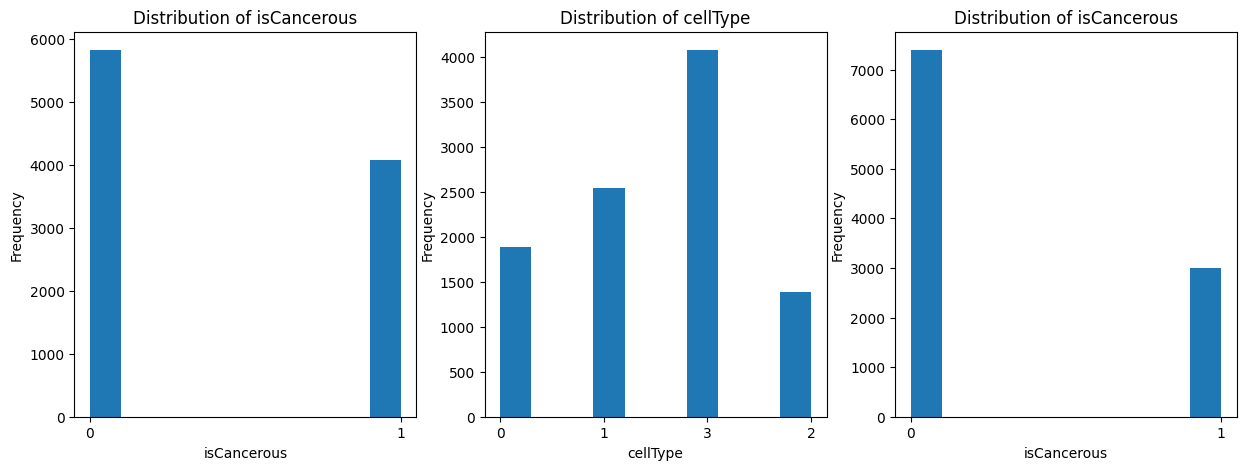

In [7]:
# Plot the histograms for main_data the first two subplots and extra_data in the last
fig, axs = plt.subplots(1, 3, figsize=(15,5))
plot_histograms(main_data, ['isCancerous'], 131)
plot_histograms(main_data, ['cellType'], 132)
plot_histograms(extra_data, ['isCancerous'], 133)
plt.show()

Based on these results, it seems that the dataset is imbalanced, with more instances of non-cancerous cells and fibroblasts compared to other cell types. Additionally, there are more instances of non-cancerous cells in the extra data compared to cancerous cells. It would be helpful to visualize the distributions of the classes using a bar plot to get a better understanding of the class imbalances.

___
### 2.2 Visualising the Images

Also, we may want to explore the images to see what the cancerous and non-cancerous cells look like and if there are any visible differences.

In [8]:
# Read patient images 
image_folder = "../data/raw/patch_images"
image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder)]

In [9]:
def plot_images_by_category(main_data, category_column, category_value, num_images, figsize=(16,4)):
    """
    Display num_images number of random cells image based on their category value in the main_data DataFrame.
    
    Parameters:
    main_data (DataFrame): the DataFrame containing the image data
    category_column (str): the name of the column containing the category values (e.g., 'isCancerous')
    category_value (int): the category value to filter on (e.g., 0 for non-cancerous)
    num_images (int): the number of images to display
    figsize (tuple): the size of the plot figure
    
    Returns:
    None
    """
    # Filter the data by the category value
    filtered_data = main_data.loc[main_data[category_column] == category_value]
    
    # Get a random selection of images
    rand_data = random.sample(range(len(filtered_data)), num_images)
    
    # Plot the images
    fig, ax = plt.subplots(num_images//10, 10, figsize=figsize)
    
    for i, row in enumerate(filtered_data.iloc[rand_data].itertuples()):
        image_path = os.path.join(image_folder, row.ImageName)
        im = np.asarray(Image.open(image_path))
        ax[i//10, i%10].imshow(im, cmap='gray')
        ax[i//10, i%10].axis('off')
        
    plt.show()


___
#### 2.2.1 Analysisng images by isCancerous

Based on the above EDA below, it seems to be possible to predict labels according to color of image. At first glance the group of images where isCancer=0 (non-cancerous) seems to have a pink or lighter undertone. While the images where isCancer=1 (cancerous) have a purple or darker color. Making them somehow differentiable. One thing we could do with this information is to perform further analysis to see if this color difference is statistically significant and whether it can be used as a predictor for the isCancerous label.


Non-cancer:


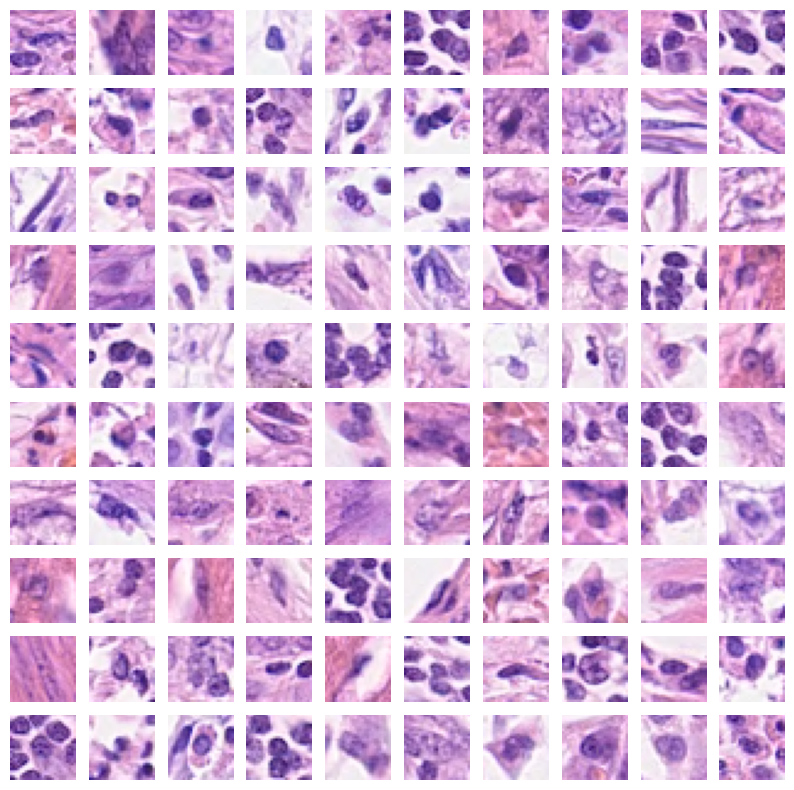

Cancer:


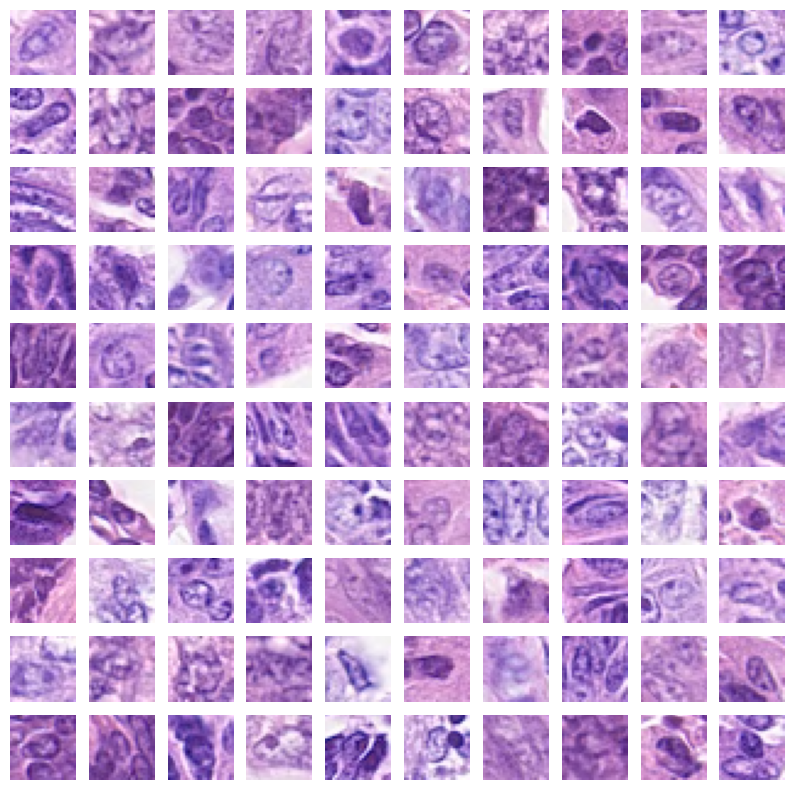

In [10]:
print("\nNon-cancer:")
plot_images_by_category(main_data, 'isCancerous', 0, 100, figsize=(10, 10))
print("Cancer:")
plot_images_by_category(main_data, 'isCancerous', 1, 100, figsize=(10, 10))

----
#### 2.2.2 Analysisng images by cellType

We could also try to explore other features that may be useful in predicting the label for our task 2, such as texture or shape of the cells in the images. Below we   plot the images to visualize the different cell types and their morphology. We also measure the area, perimeter, and circularity of cells to quantify their shape. As well as use texture analysis methods such as Haralick features to describe the texture of cells. Once we have extracted these features, we can make use of these attributes to classify cells into different categories based on their morphology. 


Fibroblast:


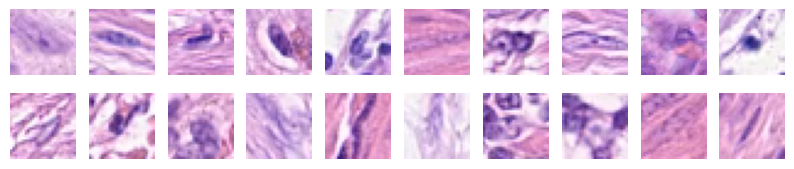

Inflammatory:


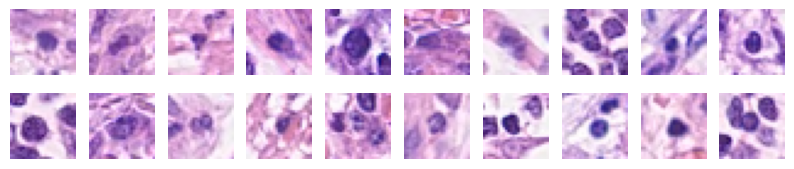

Epithelial:


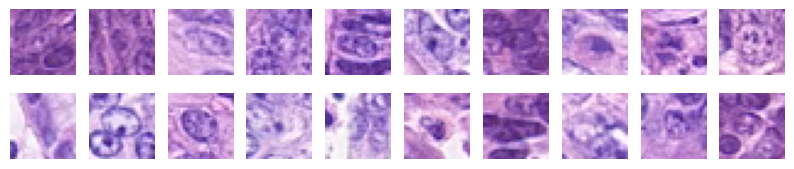

Other:


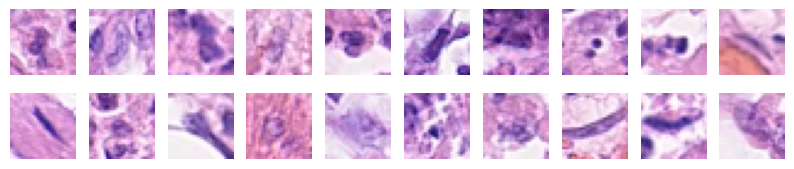

In [11]:
print("\nFibroblast:")
plot_images_by_category(main_data, 'cellType', 0, 20, figsize=(10, 2))
print("Inflammatory:")
plot_images_by_category(main_data, 'cellType', 1, 20, figsize=(10, 2))
print("Epithelial:")
plot_images_by_category(main_data, 'cellType', 2, 20, figsize=(10, 2))
print("Other:")
plot_images_by_category(main_data, 'cellType', 3, 20, figsize=(10, 2))

# REVIEW!! 

Cell morphology refers to the shape and structure of cells. We could analyze their morphology by measuring different features such as size, shape, texture, and intensity. For example, we could measure the area, perimeter, and circularity of cells to quantify their shape. Also, we could use texture analysis methods such as Haralick features to describe the texture of cells. Once these features are extracted, we could use classify cells into different categories based on their morphology. 

To measure the area, perimeter, and circularity of cells, we can use image processing techniques. One common approach is to first segment the cells from the background using thresholding or edge detection methods. Once the cells have been segmented, we calculate their area and perimeter using functions such as cv2.contourArea() and cv2.arcLength() from the OpenCV.

To calculate circularity, we use the formula 4π(area/perimeter^2), where a perfect circle has a circularity of 1.0. This calculated value for each segmented cell can be used it as a feature for classification.

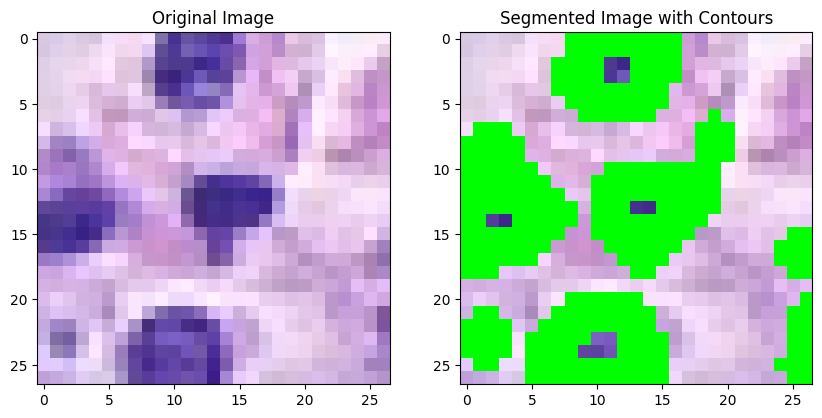

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
img = cv2.imread('../data/raw/patch_images/10000.png')

# Convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold image to segment cells
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Find contours of cells
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on original image
img_contours = np.copy(img)
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 2)

# Display images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original Image")
axs[1].imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
axs[1].set_title("Segmented Image with Contours")
plt.show()

Contrast: 378.45
Homogeneity: 0.06
Energy: 0.03


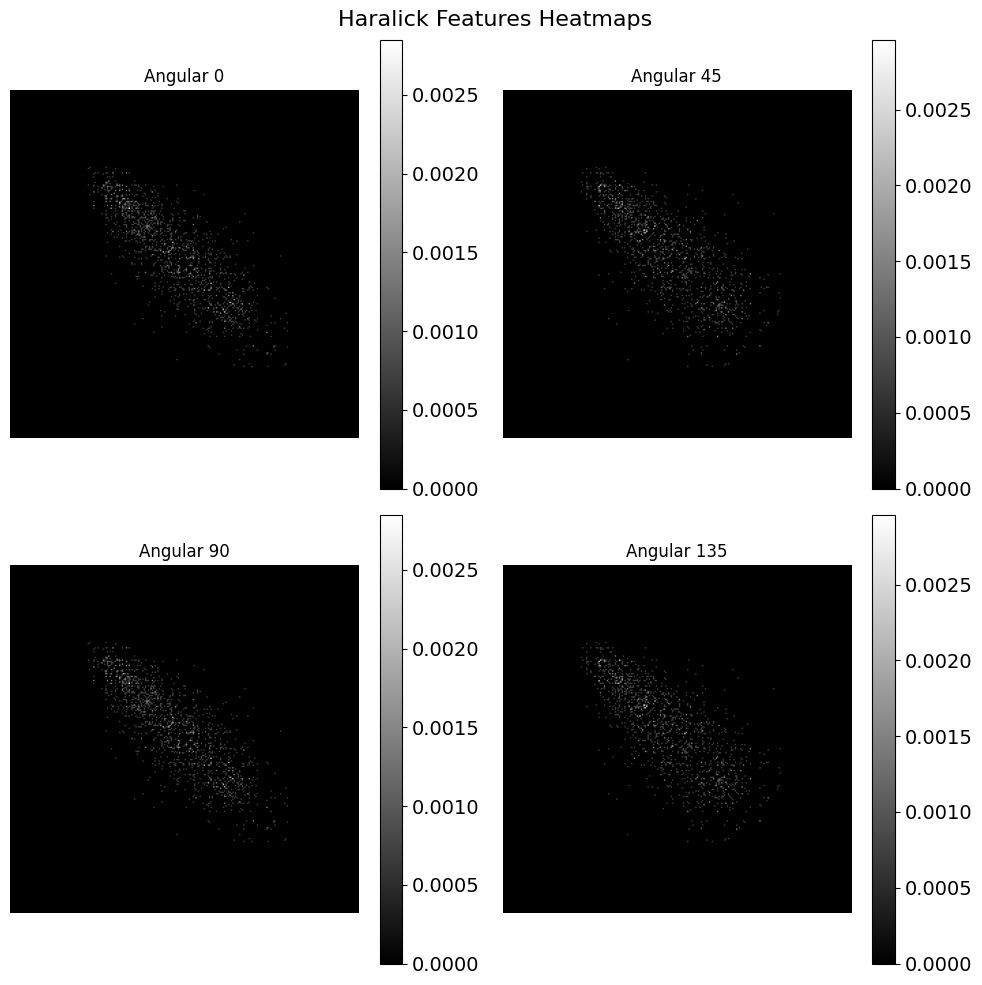

In [13]:
# Load image
img = io.imread('../data/raw/patch_images/100.png')

# Convert image to grayscale
gray = util.img_as_ubyte(io.imread('../data/raw/patch_images/100.png', as_gray=True))

# Calculate Haralick features
glcm = feature.graycomatrix(gray, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
contrast = feature.graycoprops(glcm, 'contrast')
homogeneity = feature.graycoprops(glcm, 'homogeneity')
energy = feature.graycoprops(glcm, 'energy')

# Print out results
print(f"Contrast: {contrast[0,0]:.2f}")
print(f"Homogeneity: {homogeneity[0,0]:.2f}")
print(f"Energy: {energy[0,0]:.2f}")

# Create a 2x2 subplot grid
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Plot Haralick features as heatmaps
ax[0, 0].imshow(glcm[:, :, 0, 0], cmap='gray')
ax[0, 0].set_title('Angular 0')
ax[0, 1].imshow(glcm[:, :, 0, 1], cmap='gray')
ax[0, 1].set_title('Angular 45')
ax[1, 0].imshow(glcm[:, :, 0, 2], cmap='gray')
ax[1, 0].set_title('Angular 90')
ax[1, 1].imshow(glcm[:, :, 0, 3], cmap='gray')
ax[1, 1].set_title('Angular 135')

# Add colorbars to the heatmaps
for i in range(2):
    for j in range(2):
        ax[i, j].axis('off')
        ax[i, j].imshow(glcm[:, :, 0, j], cmap='gray')
        cbar = fig.colorbar(ax[i, j].images[0], ax=ax[i, j], orientation='vertical')
        cbar.ax.tick_params(labelsize=14)

plt.suptitle('Haralick Features Heatmaps', fontsize=16)
plt.tight_layout()
plt.show()

----
#### 2.2.2 Analysisng images by patientID

We now investigate the images by patientID from a subset of patients to gain more insights into our data. We can see the images of cells from the same patient are share common morphological characteristics. If we include images of the same patient in both the training and testing sets, this can create data leakage. To avoid this we should ensure that there is no overlap between the images of patients in the training and testing sets, since the model may simply memorize the images of the patients in the training set rather than learning to recognize general patterns that can be applied to new, unseen patients. Spliting by patientID might be a good approach to avoid this.

Also, splitting the data by patient ID can make it easier to add new data to the model. When we split the data by patient ID, we can train the model on a subset of the data and then evaluate its performance on a separate subset of the data. If we later acquire new data from additional patients, we can simply add it to the training set and retrain the model. The model will then learn to recognize patterns specific to these new patients and should improve its performance on new, unseen images.

However, while the model may have learned to recognize specific patterns that are unique to the images from the patients in the training set, these features may not apply to images from new patients. To address this, we can consider using techniques to address the potential for overfitting, such as regularization or data augmentation to artificially increase the variation in the images. These techniques can help ensure that the model learns to recognize general patterns that are not unique to specific patients, and can help improve its ability to generalize to new, unseen patients.


Patient ID: 5


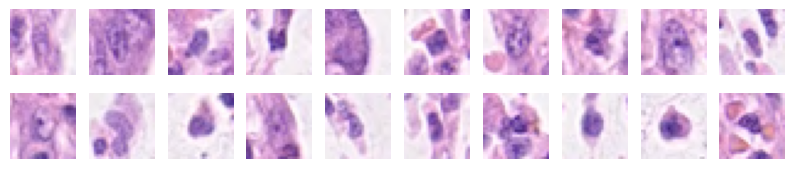

Patient ID: 39


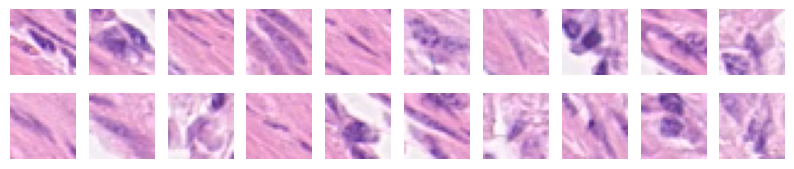

Patient ID: 23


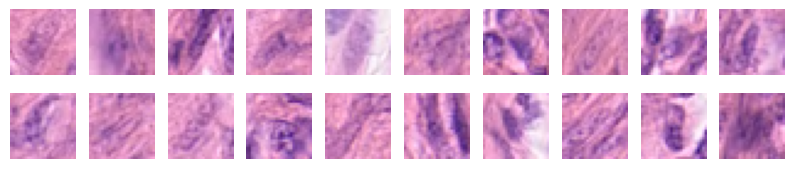

Patient ID: 15


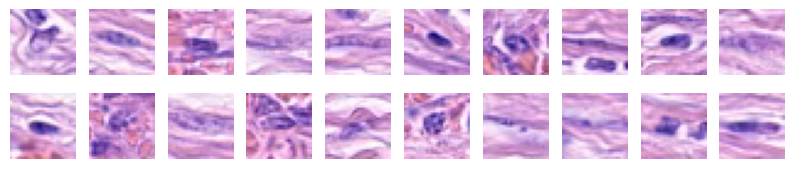

In [14]:
print("\nPatient ID: 5")
plot_images_by_category(main_data, 'patientID', 5, 20, figsize=(10, 2))
print("Patient ID: 39")
plot_images_by_category(main_data, 'patientID', 39, 20, figsize=(10, 2))
print("Patient ID: 23")
plot_images_by_category(main_data, 'patientID', 23, 20, figsize=(10, 2))
print("Patient ID: 15")
plot_images_by_category(main_data, 'patientID', 15, 20, figsize=(10, 2))

----
### 2.3 Relationship between classes

Check the relationship between the classes in main_data by getting the number of samples for each combination of isCancerous and cellType.

In [15]:
num_samples = main_data.groupby(['isCancerous', 'cellType']).size()
print(num_samples)

isCancerous  cellType
0            0           1888
             1           2543
             3           1386
1            2           4079
dtype: int64


----
# 3. Data Preprocessing
----
### 3.1 Missing Values

In [16]:
# Find missing values in main_data
main_data_missing = main_data.isna().sum()
print('Missing values in main_data:')
print(main_data_missing)

# Find missing values in extra_data
extra_data_missing = extra_data.isna().sum()
print('Missing values in extra_data:')
print(extra_data_missing)

Missing values in main_data:
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64
Missing values in extra_data:
InstanceID     0
patientID      0
ImageName      0
isCancerous    0
dtype: int64


Based on the output, it appears that there is only a single combination of isCancerous = 1 with any cellType, being this cellType = 2 (epithelial). 

There are no samples with isCancerous = 1 and cellType = 0 (fibroblast),  cellType = 1 (inflammatory), or cellType = 3 (others). It is possible that there are no samples in the dataset that have these specific combinations of isCancerous and cellType values. Alternatively, it could be that the data for these combinations is missing or excluded from the analysis.

Let´s explore how many instances there are per patientId:

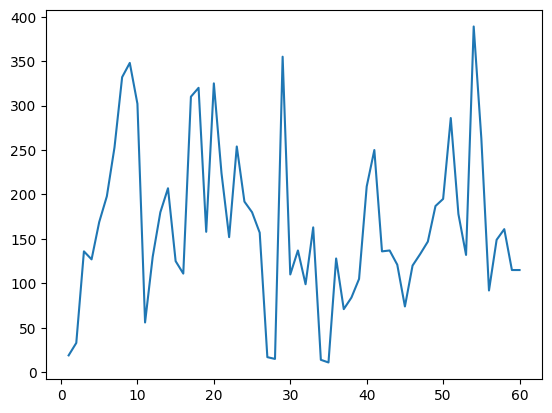

In [17]:
# Number of instances (samples) for each patient in main_data by id 
instances_per_patient = main_data.groupby('patientID').size()
plt.plot(instances_per_patient)

In [18]:
# Check for missing values within the datasets
print(main_data.isnull().sum())
print(extra_data.isnull().sum())

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64
InstanceID     0
patientID      0
ImageName      0
isCancerous    0
dtype: int64


In [19]:
# Handling missing values

In [20]:
# Scalling features
# Normalizing features

In [21]:
# Encoding categorical data

In [22]:
# assume 'df' is your DataFrame with the features
corr_matrix = main_data.corr()

# format the values as percentages with one decimal place
corr_matrix_text = corr_matrix.applymap(lambda x: f"{x:.1%}")

# print the correlation matrix as text
print(corr_matrix_text.to_string())

            InstanceID patientID cellType isCancerous
InstanceID      100.0%      4.5%   -21.9%      -43.6%
patientID         4.5%    100.0%     8.8%       -0.1%
cellType        -21.9%      8.8%   100.0%       43.7%
isCancerous     -43.6%     -0.1%    43.7%      100.0%


/var/folders/5y/fpflfs454jn0jd0z277m8x2w0000gn/T/ipykernel_98785/347958099.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = main_data.corr()


In the matrix above, we can see that "InstanceID" and "patientID" have a small positive correlation of 4.5%, "InstanceID" and "cellType" have a negative correlation of -21.9%, "InstanceID" and "isCancerous" have a negative correlation of -43.6%, "patientID" and "cellType" have a positive correlation of 8.8%, "patientID" and "isCancerous" have a negative correlation of -0.1%, "cellType" and "isCancerous" have a positive correlation of 43.7%.



In [23]:
def preprocess_image(image_path):
    # Load image
    img = cv2.imread(image_path)

    # Normalize pixel values
    img = img / 255.0

    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Threshold image to segment cells
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Find contours of cells
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate over contours and calculate area, perimeter, and circularity
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        circularity = 4 * np.pi * (area / perimeter**2)

        # Draw contour on original image
        cv2.drawContours(img, [contour], 0, (0, 255, 0), 2)

    # Convert image back to BGR for display
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    return img
